# Tutorial: supervision with ordinal labels

In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import scipy
import networkx as nx
import pacmap
import stream2 as st2
from sklearn.neighbors import NearestNeighbors

/usr/conda/envs/x/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
os.chdir('GitHub/STREAM2_tutorials/tutorial_notebooks/')

# Load data
We directly load preprocessed data subsampled ~10% of points with geosketch

Uncomment the cell below if you wish to replicate preprocessing yourself

In [3]:
adata = sc.read('../data/reprogramming/wot.h5ad')

In [4]:
adata_old = sc.read('../data/reprogramming/wot_output.h5ad')

In [5]:
## download data from https://broadinstitute.github.io/wot/tutorial/
#import wot
#
#PATH = '../../git/wot/notebooks/data/'
#
##---Path to input files
#FLE_COORDS_PATH ='data/fle_coords.txt'
#FULL_DS_PATH = 'data/ExprMatrix.h5ad'
#VAR_DS_PATH = 'data/ExprMatrix.var.genes.h5ad'
#CELL_DAYS_PATH = 'data/cell_days.txt'
#GENE_SETS_PATH = 'data/gene_sets.gmx'
#GENE_SET_SCORES_PATH = 'data/gene_set_scores.csv'
#CELL_SETS_PATH = 'data/cell_sets.gmt'
#MAJOR_CELL_SETS_PATH = 'data/major_cell_sets.gmt'
#SERUM_CELL_IDS_PATH = 'data/serum_cell_ids.txt'
#CELL_GROWTH_PATH = 'data/growth_gs_init.txt'
#
#coord_df = pd.read_csv(PATH+FLE_COORDS_PATH, index_col='id', sep='\t')
#days_df = pd.read_csv(PATH+CELL_DAYS_PATH, index_col='id', sep='\t')
#gene_set_df = pd.read_csv(PATH+GENE_SET_SCORES_PATH, index_col='id').rename(columns={'Trophoblast':'Trophoblast.identity'})
#cell_sets = wot.io.read_sets(PATH+CELL_SETS_PATH)
#serum_id = pd.read_csv(PATH+SERUM_CELL_IDS_PATH,header=None)
#adata = sc.read_h5ad(PATH+VAR_DS_PATH)
#
## subset labeled days
#adata.obs['label']=days_df
#adata=adata[~adata.obs['label'].isna()].copy()
#sc.pp.pca(adata)
#
## add annotations
#df=cell_sets.to_df()
#df['cell_sets'] = ''
#for c in df.columns[:-1]: 
#    df.loc[df[c]>0,'cell_sets']=c
#adata.obs=adata.obs.join(df)
#adata.obs.loc[adata.obs['cell_sets'].isna(),'cell_sets']='nan'
#adata.obs['cell_sets']=adata.obs['cell_sets'].astype(str)
#
#adata.obs['cell_sets_simple']=adata.obs['cell_sets'].copy()
#adata.obs['cell_sets_simple'][adata.obs['cell_sets'].isin(['Trophoblast','SpongioTropho','ProgenitorTropho','SpiralArteryTrophoGiant'])] = 'Trophoblast'
#adata.obs['cell_sets_simple'][adata.obs['cell_sets'].isin(['Neural','RadialGlia','Neuron','Astrocyte'])] = 'Neural'  
#adata.uns['cell_sets_simple_color'] = {
# 'Epithelial': '#EC8E26',
# 'IPS': '#c0c1c0',
# 'MET': '#9e50c7',
# 'Neural': '#47e026',
# 'OPC': '#7f7f7f',
# 'Stromal': '#3f4af4',
# 'Trophoblast': '#b5361a',
# 'nan': '#434342'}
#
#adata.obs['serum']='0'
#adata.obs['serum'][adata.obs.index.isin(serum_id[0].values)]='1'
#
#from geosketch import gs
#sketch_index = gs(adata.obsm['X_pca'], N=25000, replace=False,seed=0)
#s_adata = adata[sketch_index]
#s_adata.write('../data/wot.h5ad')

# Supervised dimension reduction
We can correct outlier ordinal labels by voting

In [6]:
k = 30

knn_label_vote = adata.obs['label'].copy()
dis, idx = NearestNeighbors(n_neighbors=k,n_jobs=30).fit(adata.obsm['X_pca']).kneighbors()

for i, x in enumerate(np.array(adata.obs['label'])[idx]):
    unique, count = np.unique(x, return_counts=1)
    argmax = np.argmax(count)
    if count[argmax] > k/2: 
        knn_label_vote[i] = unique[argmax]
        
adata.obs['knn_label_vote'] = knn_label_vote

We perform unsupervised dimensionality reduction as baseline

/usr/conda/envs/x/lib/python3.9/site-packages/pacmap/pacmap.py:819: UserWarning: Warning: random state is set to 0
  warnings.warn(f'Warning: random state is set to {_RANDOM_STATE}')
/usr/conda/envs/x/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


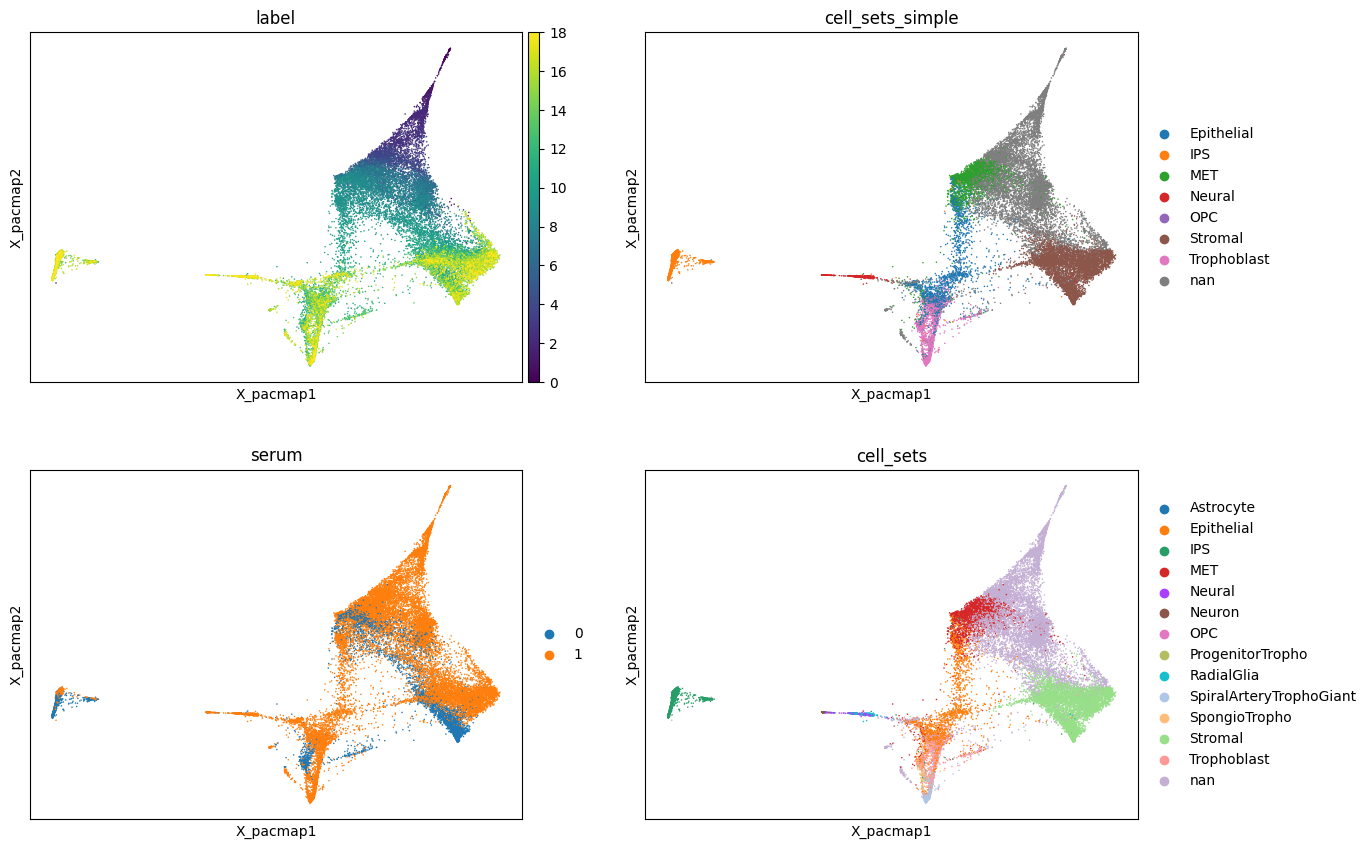

In [7]:
adata.obsm['X_pacmap'] = pacmap.PaCMAP(n_neighbors=k, distance='angular',random_state=0, FP_ratio=.4).fit_transform(adata.obsm['X_pca'])
sc.pl.embedding(adata,basis='X_pacmap',color=['label','cell_sets_simple','serum','cell_sets'],ncols=2)

In this dataset cells are already quite well ordered by time. Still there are discrepancies where earlier cells are sampled near the tip of the distribution and after cells from later days. 

In such case there is a decision to be made which notion of time we care more about respecting: pseudotime (following data density) vs wall time. If we want to more closely follow wall time, we can perform supervised dimensionality reduction by using ordinal labels and choosing a supervision strength.

/usr/conda/envs/x/lib/python3.9/site-packages/pacmap/pacmap.py:819: UserWarning: Warning: random state is set to 0
  warnings.warn(f'Warning: random state is set to {_RANDOM_STATE}')
/usr/conda/envs/x/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


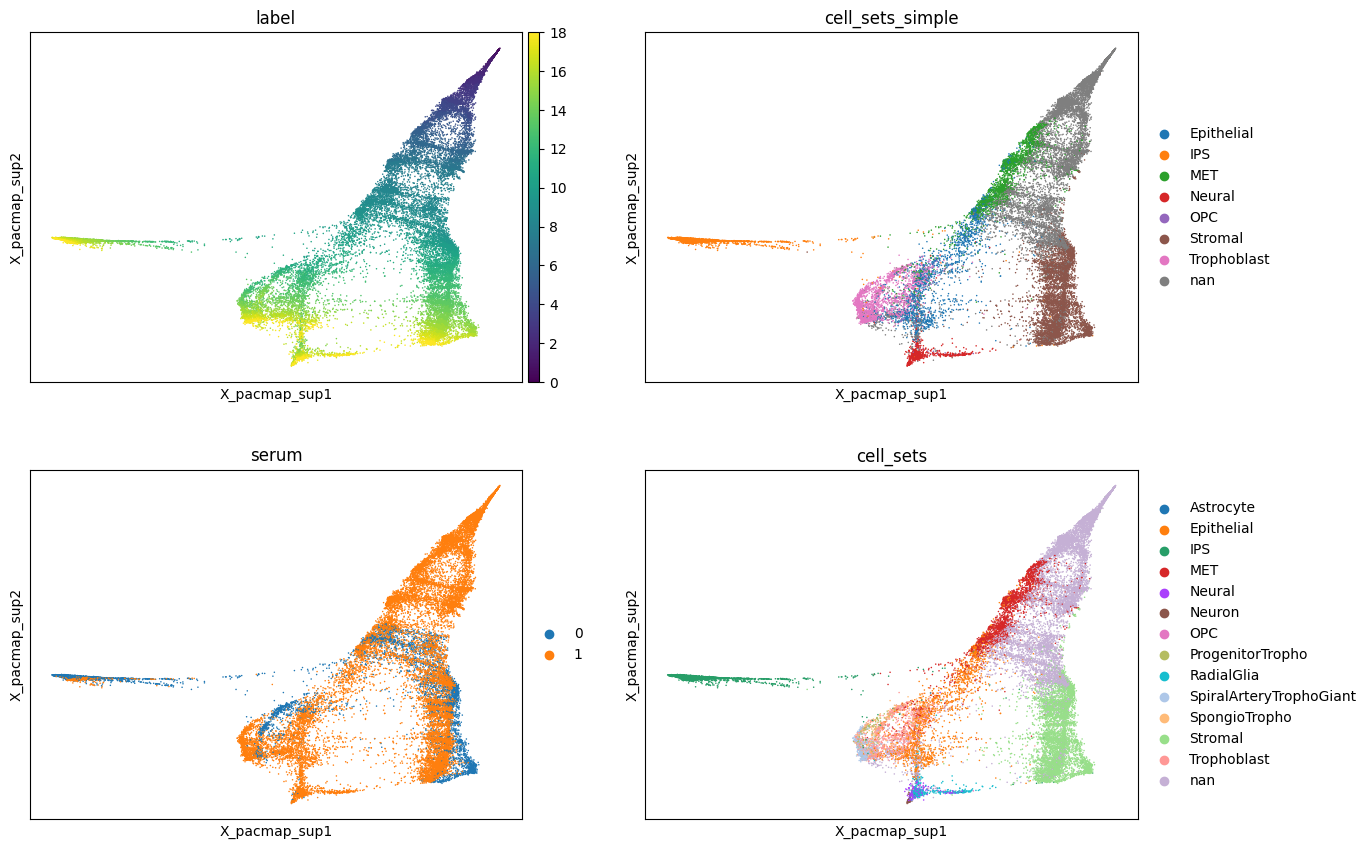

In [8]:
knn_dists,knn_idx = st2.tl.ordinal_knn(adata,obsm='X_pca',ordinal_label='label', method='force',
                                          n_neighbors = k, n_natural = 2, metric = 'cosine')


scaled_dist = np.ones_like(knn_idx,dtype='float32')
pair_neighbors = pacmap.sample_neighbors_pair(adata.obsm['X_pca'], scaled_dist, knn_idx, k)
adata.obsm['X_pacmap_sup'] = pacmap.PaCMAP(n_neighbors=k,random_state=0,FP_ratio=.4,
                                           pair_neighbors=pair_neighbors).fit_transform(adata.obsm['X_pca'])
sc.pl.embedding(adata,basis='X_pacmap_sup',color=['label','cell_sets_simple','serum','cell_sets'],ncols=2)

# Trajectory inference
Let us seed the graph with a minimum spanning tree. 
We can see that 10 clusters is not enough

Seeding initial graph...
Clustering...
K-Means clustering ...
Calculating minimum spanning tree...


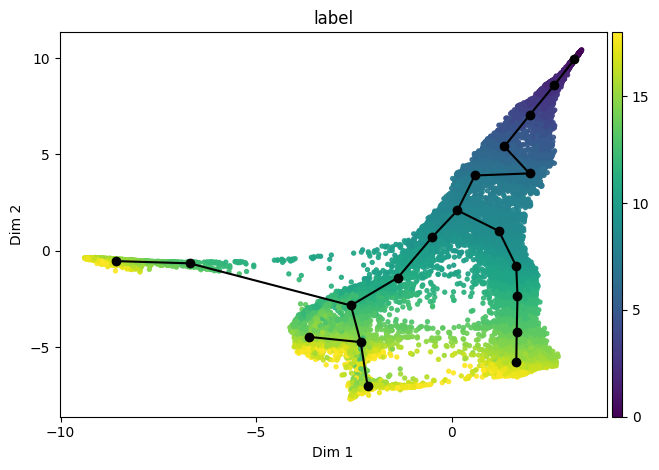

In [9]:
adata.obsm['X_dr']=adata.obsm['X_pacmap_sup']
st2.tl.seed_graph(adata,n_clusters=20,use_weights=False)
st2.pl.graph(adata,key='seed_epg',color=['label'],show_node=1)

A simple solution is to increase the number of clusters

Seeding initial graph...
Clustering...
K-Means clustering ...
Calculating minimum spanning tree...


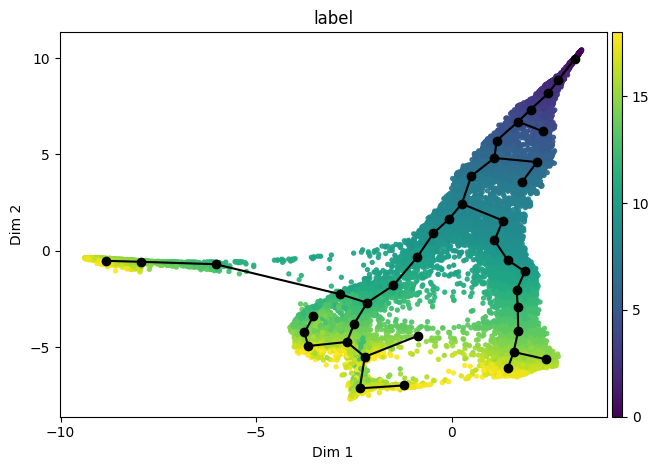

In [10]:
st2.tl.seed_graph(adata,n_clusters=40,use_weights=False)
st2.pl.graph(adata,key='seed_epg',color=['label'],show_node=1)

We can see that the seed graph is still not ideal, e.g. for IPS cells because the start of the branch
is very sparse.

We can improve this by computing density and assigning higher weights to points in sparse regions of data

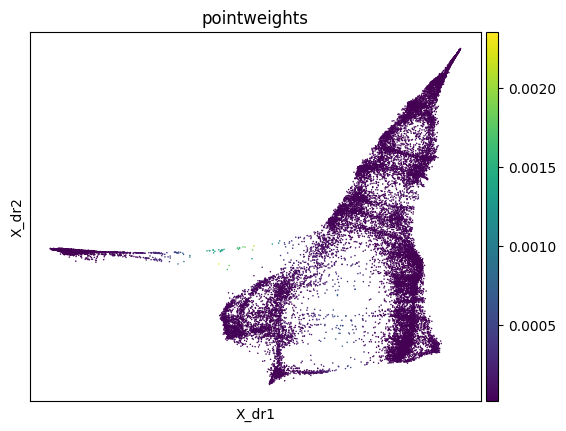

Seeding initial graph...
Clustering...
K-Means clustering ...
Calculating minimum spanning tree...


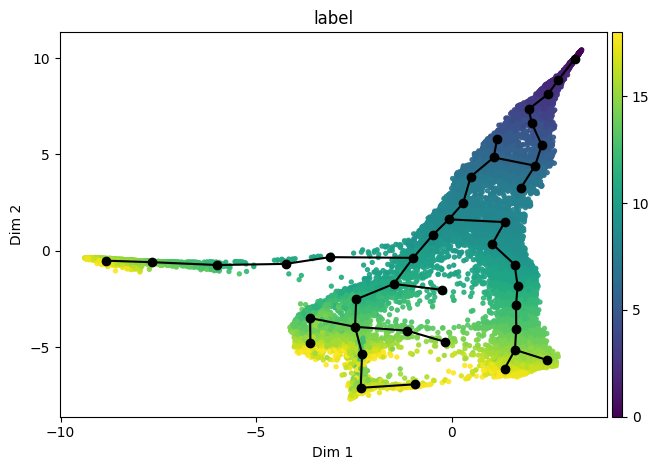

In [11]:
st2.tl.get_weights(adata,bandwidth=.5,method='fft')
sc.pl.embedding(adata,basis='X_dr',color='pointweights')

st2.tl.seed_graph(adata,n_clusters=40,use_weights=True)
st2.pl.graph(adata,key='seed_epg',color=['label'],show_node=1)

We now refine the guess by computing an unsupervised principal graph

Constructing tree 1 of 1 / Subset 1 of 1
Computing EPG with  100  nodes on  25000  points and  2  dimensions

BARCODE	ENERGY	NNODES	NEDGES	NRIBS	NSTARS	NRAYS	NRAYS2	MSE	MSEP	FVE	FVEP	UE	UR	URN	URN2	URSD

1|5||41	0.6261	41	40	26	5	0	0	0.2459	0.1936	0.9927	0.9943	0.3675	0.0127	0.5216	21.3854	0
1|4||42	0.6057	42	41	29	4	0	0	0.2562	0.2093	0.9924	0.9938	0.3361	0.0133	0.5592	23.4885	0
1|3||43	0.5972	43	42	32	3	0	0	0.2755	0.2318	0.9918	0.9931	0.3102	0.0115	0.4952	21.2918	0
1|2||44	0.5752	44	43	35	2	0	0	0.2724	0.2324	0.9919	0.9931	0.2908	0.012	0.5289	23.271	0
1|2||45	0.5686	45	44	36	2	0	0	0.2697	0.2296	0.992	0.9932	0.2866	0.0122	0.5509	24.7889	0
1|2||46	0.5629	46	45	37	2	0	0	0.2677	0.227	0.9921	0.9933	0.2843	0.0108	0.4979	22.9022	0
1|2||47	0.5574	47	46	38	2	0	0	0.2645	0.2238	0.9922	0.9934	0.2818	0.0112	0.5277	24.8028	0
1|2||48	0.5477	48	47	39	2	0	0	0.2623	0.2218	0.9922	0.9934	0.2746	0.0109	0.5229	25.1001	0
1|2||49	0.5364	49	48	40	2	0	0	0.255	0.2172	0.9925	0.9936	0.2697	0.0118	0.5758	28.2126	0


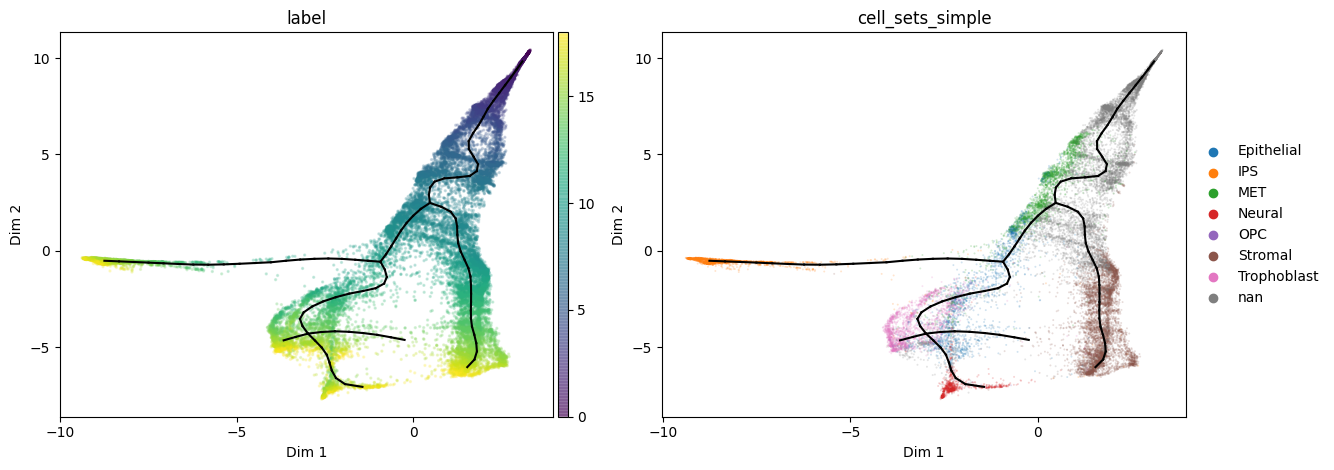

In [12]:
st2.tl.learn_graph(adata,n_nodes=100,epg_alpha=0.02,epg_mu=0.1,epg_lambda=0.01,
                   use_weights=True, GPU=True, store_evolution=True,
                   max_candidates={'AddNode2Node': 15, 'BisectEdge': 10, 'ShrinkEdge':10},
                   verbose=1,)
st2.pl.graph(adata,key='epg',color=['label','cell_sets_simple'],alpha=.2,size=2)

Since we used `store_evolution=True` we have access to graphs <br> for any number of nodes between
n_clusters of the seed graph and n_nodes

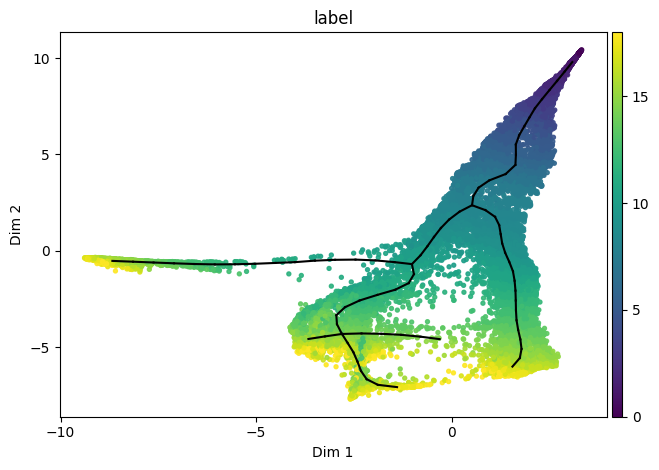

In [13]:
st2.tl.use_graph_with_n_nodes(adata,n_nodes=80)
st2.pl.graph(adata,key='epg',color=['label'])

While the structure is better than the seed graph, the result is suboptimal and some branches do not follow ordinal labels.
<br>
We can compute a supervised principal graph to get better results
<br>
<br>
Ordinal labels should be smoothed into a continuous variable before learning the supervised graph <br>
(here they are already quite smooth so we just discretize them into 3 bins as an example)

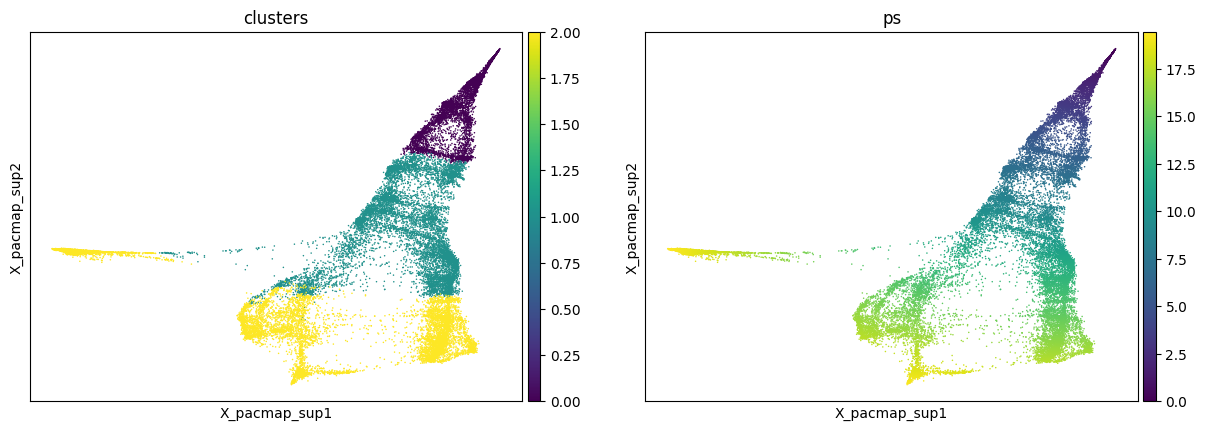

In [14]:
#define a root point
root_idx = 0
time = adata.obs['label']
bins = np.histogram(time, bins=3)[1]
adata.obs['clusters'] = np.digitize(time, bins[1:], right=True)

st2.tl.smooth_ordinal_labels(adata, root_idx, ordinal_label='clusters', obsm="X_pacmap_sup")
sc.pl.embedding(adata,'X_pacmap_sup',color=['clusters','ps'])

We then need to define 3 extra variables: root cell, ordinal labels to follow and supervision strength
- ordinal_supervision_strength = 1 means equal importance to respecting ordinal labels vs natural data order,
- ordinal_supervision_strength = 10 means ordinal labels order is 10 times more important 

Constructing tree 1 of 1 / Subset 1 of 1
The elastic matrix is being used. Edge configuration will be ignored
Computing EPG with  100  nodes on  25000  points and  2  dimensions

BARCODE	ENERGY	NNODES	NEDGES	NRIBS	NSTARS	NRAYS	NRAYS2	MSE	MSEP	FVE	FVEP	UE	UR	URN	URN2	URSD

1|5||42	0.6233	42	41	27	5	0	0	0.2688	0.2123	0.992	0.9937	0.3416	0.013	0.5449	22.8871	0
1|4||43	0.6062	43	42	30	4	0	0	0.2762	0.2188	0.9918	0.9935	0.3186	0.0115	0.4933	21.2135	0
1|3||44	0.5836	44	43	33	3	0	0	0.2697	0.2153	0.992	0.9936	0.3044	0.0095	0.4201	18.4851	0
1|2||45	0.5684	45	44	36	2	0	0	0.2648	0.212	0.9922	0.9937	0.2939	0.0097	0.4381	19.716	0
1|2||46	0.5487	46	45	37	2	0	0	0.2548	0.2061	0.9925	0.9939	0.2851	0.0088	0.4037	18.5683	0
3||47	0.5301	47	46	39	3	0	0	0.2488	0.2026	0.9926	0.994	0.274	0.0074	0.3475	16.3309	0
3||48	0.5177	48	47	40	3	0	0	0.2395	0.1958	0.9929	0.9942	0.2699	0.0083	0.3995	19.1764	0
3||49	0.5131	49	48	41	3	0	0	0.2381	0.196	0.993	0.9942	0.267	0.008	0.3929	19.2541	0
3||50	0.504	50	49	42	3	0	0	0.233

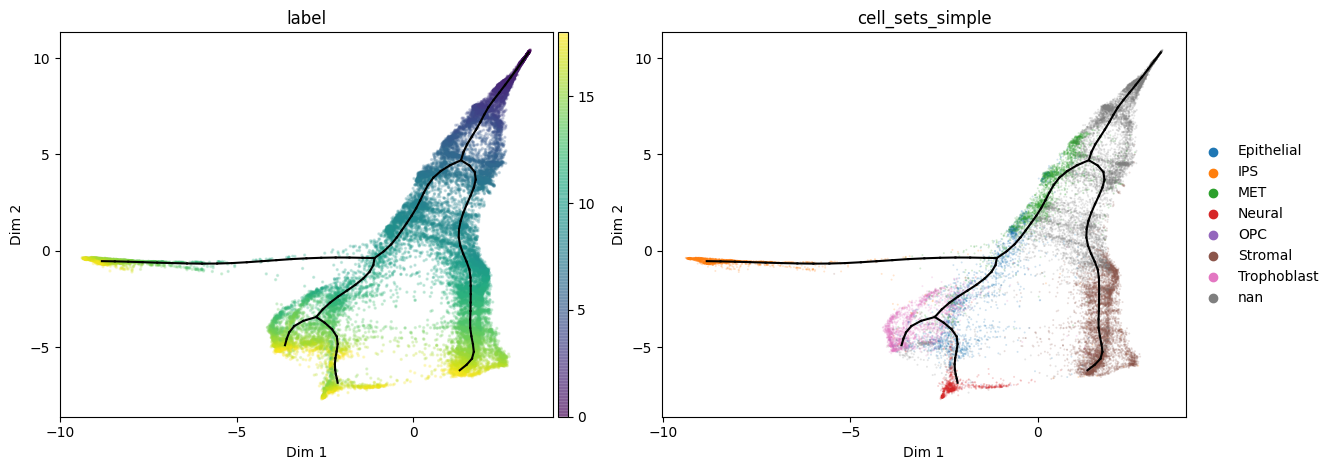

In [15]:
adata2=adata.copy()
st2.tl.learn_graph(
    adata2,
    n_nodes=100,epg_alpha=0.02,epg_mu=0.1,epg_lambda=0.01,
    GPU=True,store_evolution=True,use_weights=True,use_seed=True,
    max_candidates={'AddNode2Node': 15, 'BisectEdge': 10, 'ShrinkEdge':10},verbose=1,
                   
    # supervision parameters
    ordinal_label = 'knn_label_vote',                            #define the ordinal vector to follow
    ordinal_root_point = root_idx,                               #define a root point (e.g., cell with lowest ordinal value)
    ordinal_supervision_strength = 2.5,                            #define strength of supervision in [0, +inf).
)

st2.pl.graph(adata2,key='epg',color=['label','cell_sets_simple'],alpha=.2,size=2)

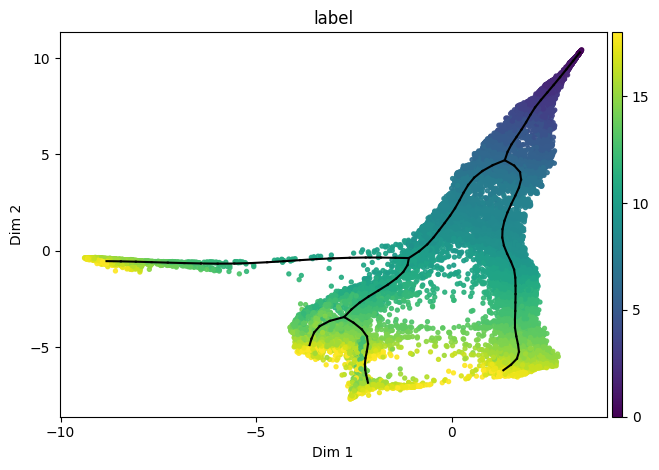

In [16]:
st2.tl.use_graph_with_n_nodes(adata2,n_nodes=100)
st2.pl.graph(adata2,key='epg',color=['label'])

# Trajectory analysis

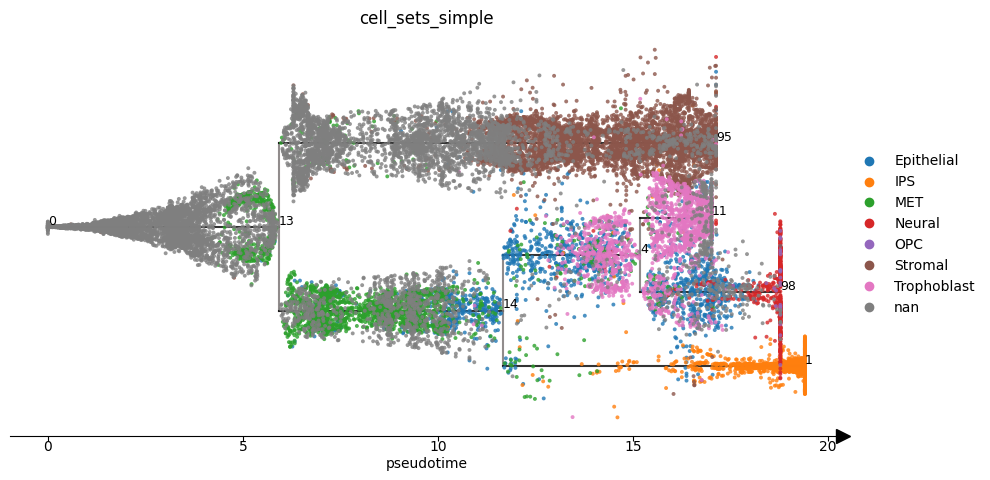

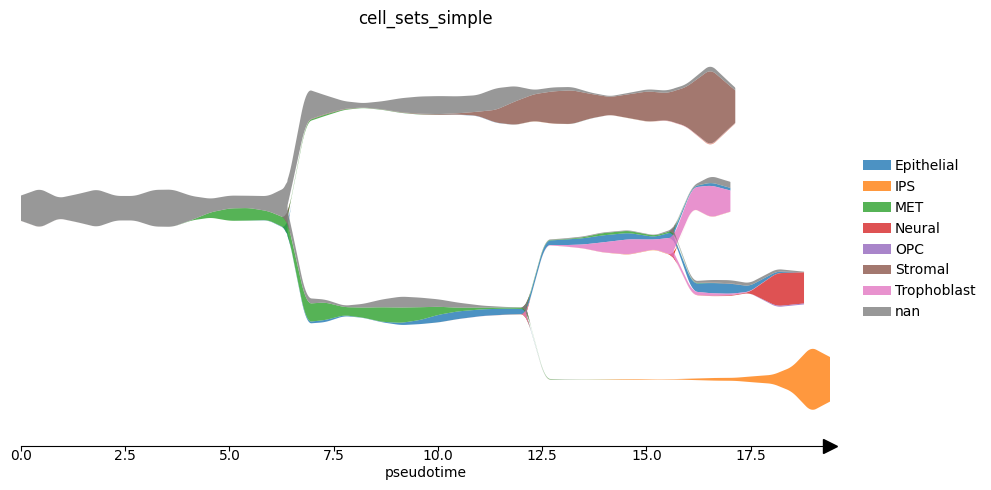

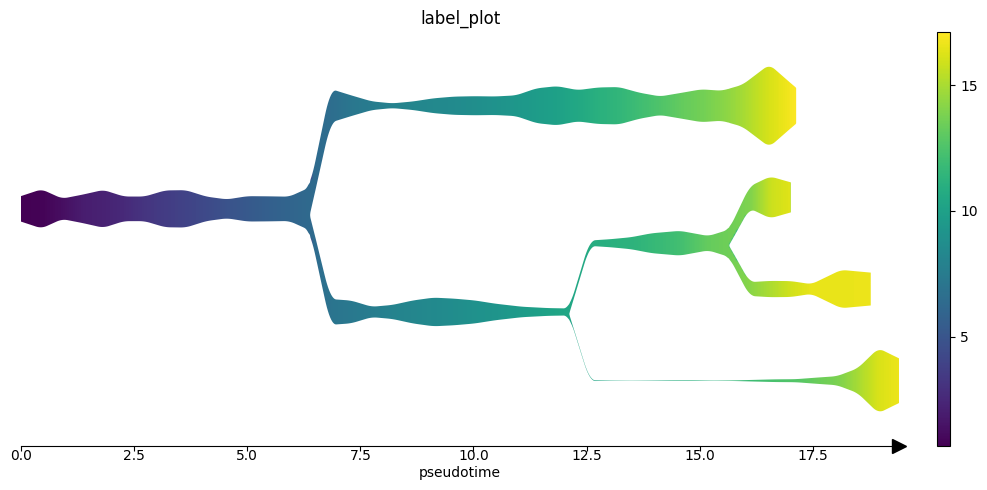

In [17]:
st2.tl.infer_pseudotime(adata2,0)
#jitter to prevent bug for equal pseudotime values
adata2.obs['label_plot']=adata2.obs['label']+1e-20*np.random.random(len(adata2))

st2.pl.stream_sc(adata2,source=0,color=['cell_sets_simple'],fig_size=(10,5))
st2.pl.stream(adata2,source=0,color=['cell_sets_simple'],fig_size=(10,5))
st2.pl.stream(adata2,source=0,color=['label_plot'],fig_size=(10,5))

# Save results

In [18]:
#anndata can fail to write these keys
del adata2.uns['epg']['conn']
del adata2.uns['seed_epg']['conn']
del adata2.uns['epg']['graph_evolution']
del adata2.uns['stream_tree']

In [19]:
adata2.write('../data/test.h5ad')